# BiLSTM + Attention Mechanism으로 IMDB 리뷰 분류하기

In [20]:
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Mecab
import numpy as np
import os
import urllib
import string
from tqdm.notebook import tqdm
import MeCab
import json

tqdm.pandas()

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mcb = Mecab()

plt.style.use("dark_background")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [ ]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [ ]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
inputs = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(inputs)

In [ ]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [ ]:
lstm, for_h_state, for_c_state, back_h_state, back_c_state = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
print(lstm.shape, for_h_state.shape, for_c_state.shape, back_h_state.shape, back_c_state.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [ ]:
state_h_state = Concatenate()([for_h_state, back_h_state]) # 은닉 상태
state_c_state = Concatenate()([for_c_state, back_c_state]) # 셀 상태

In [ ]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h_state)

In [ ]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = Model(inputs=inputs, outputs=output)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 128)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 128)     98816       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 500, 128), ( 98816       bidirectional[0][0]              
______________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_c_staterossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 566s 23ms/sample - loss: 0.4941 - accuracy: 0.7570 - val_loss: 0.3110 - val_accuracy: 0.8721
Epoch 2/5
25000/25000 [==============================] - 541s 22ms/sample - loss: 0.2530 - accuracy: 0.9074 - val_loss: 0.2852 - val_accuracy: 0.8835
Epoch 3/5
25000/25000 [==============================] - 543s 22ms/sample - loss: 0.1901 - accuracy: 0.9352 - val_loss: 0.3375 - val_accuracy: 0.8758
Epoch 4/5
  256/25000 [..............................] - ETA: 7:00

KeyboardInterrupt: ignored

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## 네이버 영화 리뷰 분류하기

In [7]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

In [8]:
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

train_data["document"] = train_data["document"].str.replace(f"[{string.punctuation}]", " ")
train_data["document"] = train_data["document"].str.replace(r" +", " ")
train_data = train_data[train_data["document"]!=" "]
train_data = train_data.dropna(axis=0)

test_data["document"] = test_data["document"].str.replace(f"[{string.punctuation}]", " ")
test_data["document"] = test_data["document"].str.replace(r" +", " ")
test_data = test_data[test_data["document"]!=" "]
test_data = test_data.dropna(axis=0)

<AxesSubplot:>

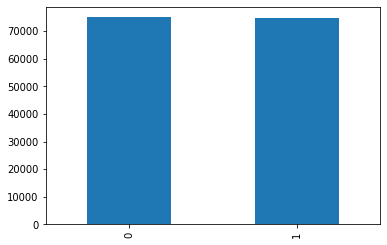

In [9]:
train_data["label"].value_c_stateounts().plot(kind="bar")

In [46]:
path = "naver_moview_review_train_c_stateorp.pkl"
if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        train_c_stateorp = json.load(f)
else:
    train_data["morphs"] = train_data["document"].progress_apply(lambda x:mcb.morphs(x))
    train_c_stateorp = train_data["morphs"].tolist()
    with open(path, "w", encoding="utf-8") as f:
        json.dump(train_c_stateorp, f, ensure_ascii=False, indent="\t")

path = "naver_moview_review_test_c_stateorp.pkl"
if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        test_c_stateorp = json.load(f)
else:
    test_data["morphs"] = test_data["document"].progress_apply(lambda x:mcb.morphs(x))
    test_c_stateorp = test_data["morphs"].tolist()
    with open(path, "w", encoding="utf-8") as f:
        json.dump(test_c_stateorp, f, ensure_ascii=False, indent="\t")

In [68]:
X_train = train_c_stateorp
X_test = test_c_stateorp

tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(X_train)

word2cnt = dict(sorted(tkn.word_c_stateounts.items(), key=lambda x:x[1], reverse=True))
cnts = list(word2cnt.values())

for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break

print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

28,379개의 단어로 전체 data의 99%를 표현할 수 있습니다.
51,980개의 단어 중 54.6%에 해당합니다.


In [69]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="<UNK>") 
tkn.fit_on_texts(X_train)

word2idx = tkn.word_index
word2cnt = sorted(tkn.word_c_stateounts.items(), key=lambda x:x[1], reverse=True)

X_train = tkn.texts_to_sequences(X_train)
X_test = tkn.texts_to_sequences(X_test)

y_train = train_data["label"]
y_test = test_data["label"]

# 빈 샘플들을 제거합니다.
idx_drop = [idx for idx, doc in enumerate(X_train) if len(doc) == 0]

X_train = np.delete(X_train, idx_drop, axis=0)
y_train = np.delete(y_train, idx_drop, axis=0)

In [70]:
lens = sorted([len(doc) for doc in X_train])
ratio = 0.99
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break
print(f"가장 긴 문장의 길이는 {np.max(lens)}입니다.")
print(f"길이가 {max_len} 이하인 문장이 전체의 {ratio:.0%}를 차지합니다.")

가장 긴 문장의 길이는 103입니다.
길이가 67 이하인 문장이 전체의 99%를 차지합니다.


In [71]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [88]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

- 이제 양방향 LSTM을 설계합니다. 단, 여기서는 양방향 LSTM을 두 층을 사용하겠습니다. 우선, 첫번째 층입니다. 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True로 해주어야 합니다.

In [77]:
inputs = tf.keras.Input(shape=(max_len,))
z = tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=128, mask_zero=True)(inputs)
z = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, dropout=0.5, return_sequences=True))(z)
lstm, for_h_state, for_c_state, back_h_state, back_c_state = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, dropout=0.5, return_sequences=True, return_state=True))(z)

In [82]:
print(lstm.shape, for_h_state.shape, back_h_state.shape, for_c_state.shape, back_c_state.shape)

(None, 67, 128) (None, 64) (None, 64) (None, 64) (None, 64)


- 각 은닉 상태나 셀 상태의 경우에는 64차원을 가지는데, lstm의 경우에는 (67\*128)의 크기를 가집니다. 각 time step에 대해서 foward 방향과 backward 방향이 연결된 hidden state벡터가 모든 시점에 대해서 존재함을 의미합니다.

In [91]:
h_state_concat = tf.keras.layers.Concatenate()([for_h_state, back_h_state])

In [92]:
print(h_state_concat.shape)

(None, 128)


In [103]:
att = BahdanauAttention(units=64) # 가중치 크기 정의
context_vector, att_weights = att(lstm, h_state_concat)

z2 = tf.keras.layers.Dense(units=20, activation="relu")(context_vector)
z2 = tf.keras.layers.Dropout(rate=0.5)(z2)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(z2)
  
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 67, 128)      3632768     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 67, 128)      98816       embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 67, 128), (N 98816       bidirectional_2[0][0]            
_______________________________________________________________________________________

In [104]:
model_path = "naver_movie_review_BiLSTM_Attention.h5"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["binary_accuracy"])

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)
    mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

    hist = model.fit(x=X_train, y=y_train, validation_split=0.2, batch_size=256, epochs=8, callbacks=[es, mc])

Epoch 1/8
468/468 [==============================] - ETA: 0s - loss: 0.3119 - binary_accuracy: 0.8799
Epoch 00001: val_binary_accuracy improved from -inf to 0.86318, saving model to naver_movie_review_BiLSTM_Attention.h5


NotImplementedError: 

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

48995/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================